In [ ]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

from keras.applications.vgg16 import VGG16 
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from scipy.spatial import distance

In [ ]:
def find_all_images(path):
    images = []
    for file in os.listdir(path):
        if file.endswith('.jpg'):
            images.append(file)
    return images

In [ ]:
path = "/content/02"

In [ ]:
images = find_all_images(path)

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    img = load_img(file, target_size=(224,224))
    img = np.array(img) 
    reshaped_img = img.reshape(1,224,224,3)
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)
    return features

553467904/553467096 [==============================] - 6s 0us/step


In [ ]:
data = {}

for img in images:
    img_path = path + "/" + img
    feat = extract_features(img_path,model)
    data[img_path] = feat

In [ ]:
filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))
print(feat.shape)

feat = feat.reshape(-1,4096)
print(feat.shape)

(1916, 1, 4096)
(1916, 4096)


In [ ]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [ ]:
kmeans = KMeans(n_clusters=13,n_jobs=-1, random_state=22)
kmeans.fit(x)

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 69 to 30


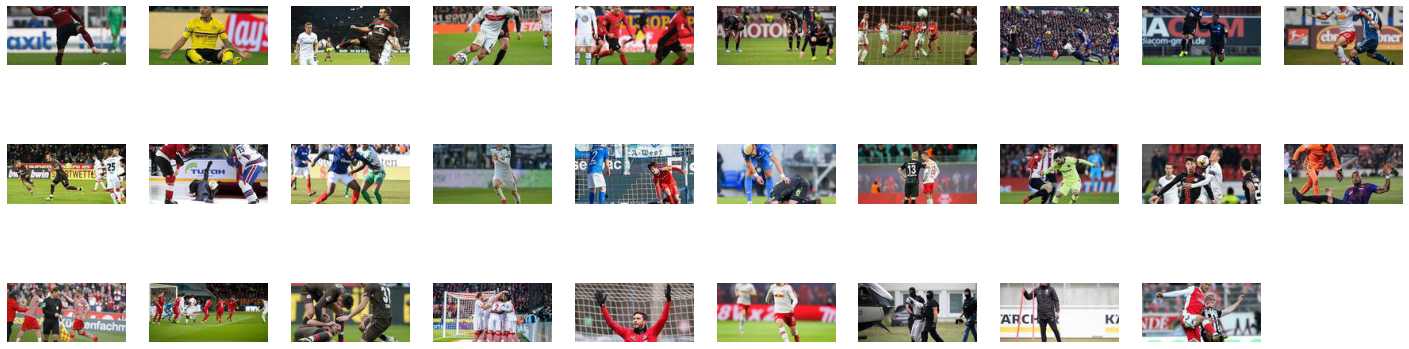

In [ ]:
view_cluster(10)

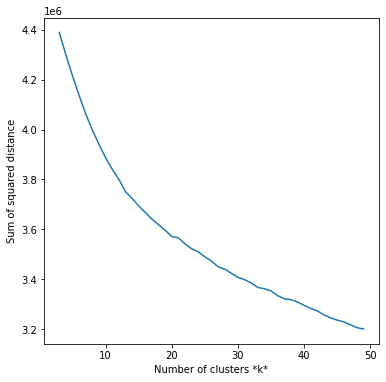

In [ ]:
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [ ]:
df = pd.DataFrame(np.array(list(data.values()))[:,0],
                  index=list(data.keys()))

In [ ]:
cos = distance.cdist(df,df, "cosine")

In [ ]:
from heapq import nsmallest
from collections import defaultdict

matrix = cos
d = defaultdict(list)

for i in range(len(matrix)):
    for j in range(i):
        d[matrix[i][j]].append((i, j))

for value, positions in nsmallest(100, d.items(), key=lambda item: item[0]):
    print(value, positions)

0.0 [(315, 157), (469, 349), (632, 239), (726, 62), (785, 514), (805, 81), (830, 647), (854, 289), (969, 517), (1011, 243), (1013, 514), (1013, 785), (1036, 364), (1075, 857), (1102, 1064), (1161, 694), (1224, 1007), (1287, 989), (1303, 1211), (1307, 802), (1342, 414), (1373, 156), (1398, 125), (1522, 1296), (1561, 943), (1580, 1274), (1591, 354), (1612, 236), (1628, 130), (1655, 81), (1655, 805), (1730, 1244), (1824, 1252), (1825, 1462), (1828, 410), (1844, 1589), (1877, 1709), (1901, 1554)]
1.1102230246251565e-16 [(1198, 578), (1512, 351), (1714, 938), (1880, 481)]
2.220446049250313e-16 [(357, 232), (510, 218), (992, 232), (992, 357), (1042, 232), (1042, 357), (1042, 992), (1563, 232), (1563, 357), (1563, 992), (1563, 1042), (1574, 722), (1748, 232), (1748, 357), (1748, 992), (1748, 1042), (1748, 1563)]
0.012339771345200923 [(1098, 663)]
0.012358107829998466 [(1469, 1250)]
0.017583626442760014 [(1414, 979)]
0.017592631802695546 [(872, 134)]
0.023900423563497863 [(617, 514), (785, 617